# TDEsAsciiMetric


This notebook demonstrates how to use TDEsAsciiMetric which calculate what fraction of an input TDE lightcurve would be detected. Paired with a spatial slicer, you can obtain the skymap or the observed light curve. 


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

In [2]:
# from mafContrib import TDEsAsciiMetric
from mycode import TDEsAsciiMetric

## Simulated TDE light curve and the minimum requirement

The TDEsAsciiMetric provides some prameters to meet the requirement of detection TDEs.

- nObsTotal: Required total number of observations in each band.
- nObsPrePeak: Required Number of observations before peak.
- nObsNearPeak: Required number of observations in each band near peak.
- nFiltersNearPeak: Required number of filters near peak.
- nObsPostPeak: Required number of observations after peak.
- nFiltersPostPeak: Required number of number of filters after peak.

**Minimum requirement for detection TDEs** proposed by [Sjoert van Velzen](https://github.com/sjoertvv)

- one detection before peak in any band to make sure we can roughly resolve the time/flux at peak,  set nObsPrePeak=1;
- detections in three different bands within 10 days of peak to measure the color at peak, set nFiltersNearPeak=3, and nearPeakT=10;
- detections at least two bands post peak within two weeks to measure the change of color, set nFiltersPostPeak=2, and postPeakT=14.


**set parameters according to input lightcurve template and minimum requirement**

| parameters | value | meaning| 
| ---        | ---   |
| epochStart | -22   |  Start epoch of input light curve |
| peakEpoch  | 0     |  Peak epoch of input light curve  |
| nearPeakT  | 10    |  Within 10 days around peakEpoch are considered as near peak |
| postPeakT  | 14    |  Within two weeks after peakEpoch are considered as post peak |
| nPhaseCheck| 1     |  Number of phases, 1 means only check the same phase as in ascii file |
| nObsTotal  |{'u': 0, ...}| Number of total observations in each band |
| nObsPrePeak| 1     | Number of observations before peak |
|nObsNearPeak |{'u': 0, ...}| Number of observations in each band |
|nFiltersNearPeak | 3 | Number of filters near peak |
|nObsPostPeak | 0 | Number of observations after peak |
|nFiltersPostPeak | 2 | Number of filters after peak |

In [3]:
# light curve file
asciifile = 'TDEfaintfast_z0.1.dat'

# query columns 
mjdCol = 'observationStartMJD'
m5Col = 'fiveSigmaDepth'
filterCol = 'filter'
detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}

# light curve parameters
epochStart = -22
peakEpoch = 0
nearPeakT = 10
postPeakT = 14 # two weeks
nPhaseCheck = 1

# condition parameters
nObsTotal = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}
nObsPrePeak = 1
nObsNearPeak = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}
nFiltersNearPeak = 3
nObsPostPeak = 0 
nFiltersPostPeak = 2


Let's plot the light curve template. 

In [4]:
# plot light curve
def plotlc(dataSlice, time_key='time', mag_key='mag', filter_key='filter', err_key = None,
          peakEpoch=None, nearPeakT=None, postPeakT=None):
    # Input: dataSlice, pandas DataFrame or numpy ndarray
    
    colors = {'u':'k', 'g':'b', 'r':'r', 'i':'m', 'z':'orange', 'y':'c'}
    
    plt.figure(figsize=(10, 6))
    for f in np.unique(dataSlice[filter_key]):
        fmatch = dataSlice[filter_key]==f
        time = dataSlice[time_key][fmatch]
        mag = dataSlice[mag_key][fmatch]
        
        # draw a vertical line to denote pre/near/post peak
        if peakEpoch!=None:
            plt.axvline(x=peakEpoch, linestyle='-', linewidth=1)
            plt.axvline(x=peakEpoch-nearPeakT/2, linestyle='--', linewidth=1)
            plt.axvline(x=peakEpoch+nearPeakT/2, linestyle='--', linewidth=1)
            plt.axvline(x=peakEpoch+nearPeakT/2+postPeakT, linestyle='--', linewidth=1)
        
        if err_key!=None:
            mag_err = dataSlice[err_key][fmatch]
            plt.errorbar(time, mag, yerr=mag_err, color=colors[f], fmt='.', label=f)
        else:
            plt.scatter(time, mag, color=colors[f], marker='*', label=f)

    plt.legend()
    plt.xlabel('days')
    plt.ylabel('mag')
    plt.ylim(plt.ylim()[::-1])

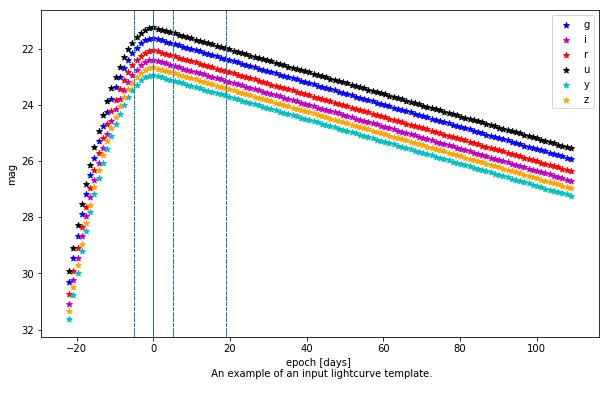

In [40]:
asciifile = 'TDEfaintfast_z0.1.dat'

lcv_template = np.genfromtxt(asciifile, dtype=[('ph', 'f8'), ('mag', 'f8'), ('flt', 'S1')])

df = pd.DataFrame()
df['ph'] = lcv_template['ph']
df['mag'] = lcv_template['mag']
df['flt'] = lcv_template['flt'].astype(str)

plotlc(df, time_key='ph', mag_key='mag', filter_key='flt', 
       peakEpoch=peakEpoch, nearPeakT=nearPeakT, postPeakT=postPeakT)

plt.xlabel('epoch [days] \n An example of an input lightcurve template. \n' )


## Opsim database

Connect to opsim database and get the proposalId

In [6]:
# connect to opsim database
opsdb_baseline = db.OpsimDatabase('baseline2018a.db')
opsdb_baseline.fetchPropInfo()

({1: 'NorthEclipticSpur',
  2: 'SouthCelestialPole',
  3: 'WideFastDeep',
  4: 'GalacticPlane',
  5: 'DeepDrillingCosmology1'},
 {'WFD': [3], 'DD': [5], 'NES': [1]})

In [9]:
# output directory
outDir = 'outdir'
resultsDb = db.ResultsDb(outDir=outDir)


### get skymap

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<730 and proposalId=3 for columns ['fieldDec', 'filter', 'observationStartMJD', 'fiveSigmaDepth', 'fieldRA']
Found 391886 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<730 and proposalId=3" constraint now.


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_maf/2.8.0.sims/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_maf/2.8.0.sims/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.00573785  dipole: lon: 130.148, lat: -72.6518, amp: 0.030262
Plotting complete.


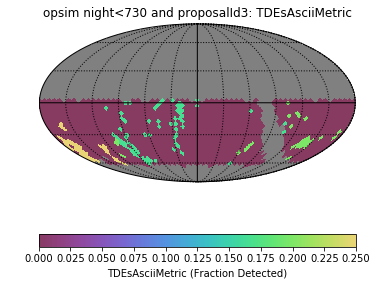

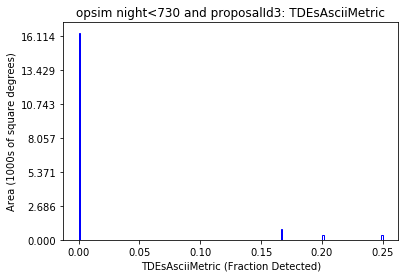

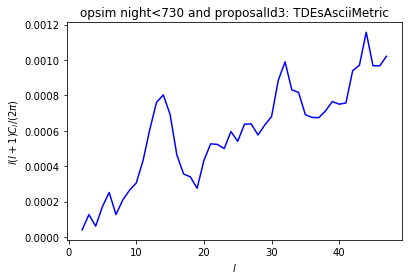

In [10]:
# get skymap by set dataout=False and use HealpixSlicer()
transmetric = TDEsAsciiMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT, nPhaseCheck=nPhaseCheck,
                              nObsTotal= nObsTotal, nObsPrePeak=nObsPrePeak, 
                              nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                              nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                              dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<730 and proposalId=3'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_baseline, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

We can create a pd.DataFrame and save the skymap info for later use.

In [11]:
baseline2018_skymap = transmetricSky.metricValues

# create a dataframe and save to csv file
df = pd.DataFrame(baseline2018_skymap)
df['ipix'] = df.index 
df['ra'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[0]
df['dec'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[1]
df['metricValues'] = df[0]
del df[0]
df.to_csv('./opsdb/baseline2018_skymap.csv', index=False, na_rep='NaN')

df.head()

,ipix,ra,dec,metricValues
0,0,45.0,87.075820,NaN
1,1,135.0,87.075820,NaN
2,2,225.0,87.075820,NaN
3,3,315.0,87.075820,NaN
4,4,22.5,84.149733,NaN


In [12]:
# view all metric values 
np.unique(baseline2018_skymap)

masked_array(data = [0.0 0.16666666666666666 0.2 0.25 --],
             mask = [False False False False  True],
       fill_value = -1.6375e+30)

In [14]:
# get the all ipixes for a metric value
np.where(baseline2018_skymap==0.2) 

(array([1549, 1803, 1867, 1869, 1929, 2124, 2241, 2369, 2372, 2375, 2418,
        2437, 2438, 2439, 2483, 2502, 2503, 2504, 2515, 2565, 2566, 2567,
        2568, 2579, 2640, 2698, 2724, 2788]),)

In [15]:
# get the (ra,dec) for a ipix
hp.pix2ang(ipix=1549, nside=16, lonlat=True)

(255.9375, 0.0)

### get light curve 

In [17]:
## get light curve by set dataout=True and use UserPointSlicer()
transmetric = TDEsAsciiMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, detectSNR=detectSNR,
                 epochStart=epochStart, peakEpoch=peakEpoch, nearPeakT=nearPeakT, nPhaseCheck=nPhaseCheck,
                 nObsTotal= nObsTotal,nObsPrePeak=nObsPrePeak, 
                 nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                 nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                 dataout=True)
# ra,dec of ipix 
ra = np.array([255.9375])
dec = np.array([0.0])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<730 and proposalId=3'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_baseline, outDir=outDir, resultsDb=resultsDb)
group.runAll()


Finish initializing metric
Querying database SummaryAllProps with constraint night<730 and proposalId=3 for columns ['fieldDec', 'filter', 'observationStartMJD', 'fiveSigmaDepth', 'fieldRA']
Found 391886 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


The output metricValues is a list of dictionaries for each phase(tshift). Each dictionary contains arrays of 

|  variable   |  meaning   |
| --- | --- |
| 'tshift' | the phase shift of the light curve|
| 'expMJD' | the time column |
| 'm5'     | the fiveSigmaDepth |
|'filters' | filters |
| 'lcNumber'| number of light curve|
|'lcEpoch' | epoch of the light curve |
| 'prePeakCheck' | equals True for prePeak observations |
| 'nearPeakCheck'| equals True for nearPeak observations|
| 'postPeakCheck'| equals True for postPeak observations|
| 'lcMags'| magnitudes of the light curve|
| 'lcSNR' | signal to noise ratio|
| 'lcMagsStd'| standard deviation of magnitudes|
| 'lcAboveThresh'| equals True if for detected magnitudes|
| 'detected' |equals True if this light curve was detected|

In [28]:
# save file and plot light curve
output_dict_list = transmetricSky.metricValues.data[0]
df = pd.DataFrame(output_dict_list[0])

df.to_csv('./opsdb/baseline2018_lc.csv', index=False)

df.head()

,detected,expMJD,filters,lcAboveThresh,lcEpoch,lcMags,lcMagsStd,lcNumber,lcSNR,m5,nearPeakCheck,postPeakCheck,prePeakCheck,tshift
0,True,60025.411539,r,False,-22.000000,30.750000,4.681013,0.0,0.013598,24.336226,False,False,True,0.0
1,True,60030.400613,y,False,-17.010926,28.135845,3.958639,0.0,0.026793,22.458489,False,False,True,0.0
2,True,60031.396019,i,False,-16.015521,27.012526,1.656340,0.0,0.277959,23.875053,False,False,True,0.0
3,True,60033.377095,z,False,-14.034444,26.199636,1.340547,0.0,0.410288,23.484934,False,False,True,0.0
4,True,60033.402662,z,False,-14.008877,26.187085,1.387366,0.0,0.386283,23.406924,False,False,True,0.0


The output light curve can be plotted use the same function defined above.

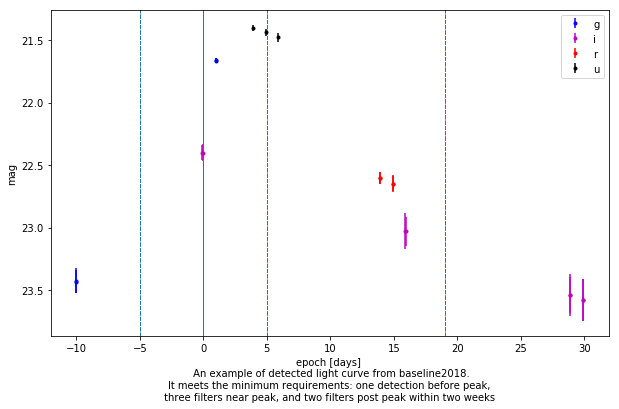

In [39]:
# load from csv
# df = pd.read_csv('./opsdb/baseline2018_lc.csv')

# plot all light curve
# plotlc(df[ (df['lcAboveThresh'])], time_key='expMJD', mag_key='lcMags', filter_key='filters', err_key='lcMagsStd')

# plot a specific light curve
plotlc(df[ (df['lcAboveThresh']) & (df['lcNumber']==0)], time_key='lcEpoch', mag_key='lcMags', filter_key='filters', err_key='lcMagsStd', 
       peakEpoch=peakEpoch, nearPeakT=nearPeakT, postPeakT=postPeakT)

plt.xlabel('epoch [days] \n An example of detected light curve from baseline2018.\n' + 
           'It meets the minimum requirements: one detection before peak,\n three filters near peak, and two filters post peak within two weeks ')



Other opsim databases can be explored by following the same procedure.